<a href="https://colab.research.google.com/github/aasheshvn/Machine-Learning/blob/master/Facial_Emotion_Recognition/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.special import softmax
import math
import tensorflow as tf
import cv2 as cv
from google.colab.patches import cv2_imshow

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

## Loading the data

In [9]:
df = pd.read_csv("fer2013.csv")
df.shape

(35887, 3)

The dataset has 35,887 images

## Preview of the data

In [10]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Each image observation is in the form of 48 x 48 pixels with each pixel ranging from values 0 to 255. 

## Frequency of observations for each emotion

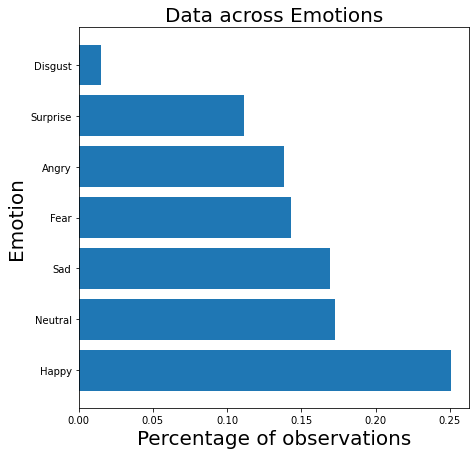

In [158]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
emotion_frequency = df['emotion'].value_counts(normalize = True).reset_index()
emotion_frequency.columns = ['emotion', 'frequency']
emotion_frequency['emotion'] = emotion_frequency['emotion'].map(emotions)

plt.figure(figsize=(7,7))
plt.barh(y=emotion_frequency['emotion'], width=emotion_frequency['frequency'],align='center')
plt.xlabel("Percentage of observations",fontsize=20)
plt.ylabel("Emotion",fontsize=20)
plt.title("Data across Emotions",fontsize=20)
plt.show()

## Formatting the image/training data suitable for image processing

In [0]:
X = []
input_pixels = df['pixels'].tolist()
for image in input_pixels:
    image_pixels = [int(i) for i in image.split(' ')]
    image_pixels = np.asarray(image_pixels).reshape(48, 48)  ### Reshaping the image data into 48x48
    X.append(image_pixels.astype('float32'))

X = np.asarray(X)
### Adding an additional feature to make the input suitable for CNN. It also represents the number of channels
X = np.expand_dims(X,-1)
X_data = X 

## Input data standardization

The input pixels are ranging from 0 to 255 and needs to be brought into a normal distribution. This is performed by subtracting the input pixels by the subtracting it from its mean and dividing by its Standard deviation

In [98]:
X = X - np.mean(X, axis=0)
X = X/np.std(X, axis=0)
X.max()

2.450381

## One hot Encoding for the target variable - emotion

In [99]:
y = pd.get_dummies(df['emotion']).to_numpy()
y.shape

(35887, 7)

## Preview of images

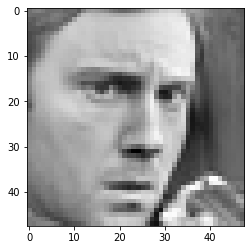

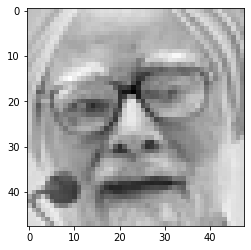

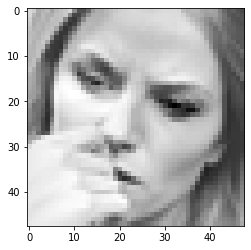

In [100]:
for image in range(3):
    plt.imshow(X[image].reshape((48, 48)), interpolation='none', cmap='gray')
    plt.show()

## Data Partitioning

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Functions Definitions

## Weights Initialisation

In [0]:
def initialise_weights(shape):
    initial_weights = tf.truncated_normal(shape,mean=0,stddev=0.1)
    return tf.Variable(initial_weights)

## Bias Initialisation

In [0]:
def initialise_bias(shape):
    initial_bias = tf.constant(0.1,shape=shape)
    return tf.Variable(initial_bias)

## Convolution Operation

In [0]:
def convolution_operation(x,weights):
    return tf.nn.conv2d(x,weights,strides= [1,1,1,1],padding='SAME')         ###Zero padding included

## Max Pooling operation

In [0]:
def max_pooling(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')  ###Zero padding included

## Convolutional layer

In [0]:
def convolutional_layer(input_x,shape):
    weights = initialise_weights(shape)
    bias = initialise_bias([shape[3]])
    return tf.nn.relu(convolution_operation(input_x,weights)+bias)

## Fully connected layer

In [0]:
def fully_connected(input_layer,size):
    input_size = int(input_layer.get_shape()[1])
    weights = initialise_weights([input_size,size])
    bias = initialise_bias([size])
    return tf.matmul(input_layer,weights) + bias

## Defining the Convolutional Neural Network Architechture

In [0]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32,shape = [None,48,48,1])   ### Shape = [Batch Size, Height, Weight, Number of channels]
y = tf.placeholder(tf.float32,shape = [None,7])         ### Shape = [Batch Size, Number of target classes]

In [109]:
con_layer_1 = convolutional_layer(x,shape=[3,3,1,64])            ### Filter size = 3x3. Number of filters = 64
con_layer_1.get_shape()

TensorShape([Dimension(None), Dimension(48), Dimension(48), Dimension(64)])

In [110]:
con_layer_2 = convolutional_layer(con_layer_1,shape=[3,3,64,64])  ### Filter size = 3x3. Number of filters = 64
### Batch Normalisation is performed to ensure the convolutional operation output stays within a limit of 0 to 1, 
### which is moves forward as the input to the next layer
con_layer_2 = tf.layers.batch_normalization(con_layer_2)
### Max pooling helps in reducing the dimensionality of the data by down-sampling the image representation.
con_layer_2_pooling = max_pooling(con_layer_2)                    ### Pooling layer of window size 2x2
con_layer_2_pooling.get_shape()

TensorShape([Dimension(None), Dimension(24), Dimension(24), Dimension(64)])

In [111]:
con_layer_3 = convolutional_layer(con_layer_2_pooling,shape=[3,3,64,128])  ### Filter size = 3x3. Number of filters = 128
con_layer_3 = tf.layers.batch_normalization(con_layer_3)
con_layer_3.get_shape()

TensorShape([Dimension(None), Dimension(24), Dimension(24), Dimension(128)])

In [112]:
con_layer_4 = convolutional_layer(con_layer_3,shape=[3,3,128,128])     ### Filter size = 3x3. Number of filters = 128
con_layer_4 = tf.layers.batch_normalization(con_layer_4)
con_layer_4_pooling = max_pooling(con_layer_4)                         ### Pooling layer of window size 2x2
con_layer_4_pooling.get_shape()

TensorShape([Dimension(None), Dimension(12), Dimension(12), Dimension(128)])

In [113]:
con_layer_5 = convolutional_layer(con_layer_4_pooling,shape=[3,3,128,256])    ### Filter size = 3x3. Number of filters = 256
con_layer_5 = tf.layers.batch_normalization(con_layer_5)
con_layer_5_pooling = max_pooling(con_layer_5)                                ### Pooling layer of window size 2x2
con_layer_5_pooling.get_shape()

TensorShape([Dimension(None), Dimension(6), Dimension(6), Dimension(256)])

## Defining the fully connected layers

In [0]:
holdout_prob = tf.placeholder(tf.float32)                           ### Important to have a holdout layer to avoid over-fitting
con_layer_5_flat = tf.reshape(con_layer_5_pooling,[-1,6*6*256])     ### Flattening the final convolutional layer
dense_layer_1 = tf.nn.relu(fully_connected(con_layer_5_flat,1024))  ### Dense layer 1 with 1024 neurons
dense_layer_1_dropout = tf.nn.dropout(dense_layer_1,keep_prob=holdout_prob)

In [115]:
dense_layer_2 = tf.nn.relu(fully_connected(dense_layer_1_dropout,512))  ### Dense layer 2 with 512 neurons
dense_layer_2_dropout = tf.nn.dropout(dense_layer_2,keep_prob=holdout_prob)
dense_layer_2_dropout.get_shape()

TensorShape([Dimension(None), Dimension(512)])

In [0]:
y_pred = fully_connected(dense_layer_2_dropout,7)                     ### Output layer with 7 neurons (7 classes of emotions)

## Defining Loss and Optimisation Function

In [0]:
losses = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(losses)

In [118]:
batch_size = 64
training_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# training_tf = training_tf.shuffle(X_train.shape[0])
training_tf = training_tf.batch(batch_size)
iterator  = training_tf.make_initializable_iterator()
data = iterator.get_next()

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(101):
      sess.run(iterator.initializer)
      try:
        while True:
          batch = sess.run(data)                ### Splitting the training data into batches of 64
          batch_x = batch[0]
          batch_y = batch[1]
          sess.run(train,feed_dict={x:batch_x,y:batch_y,holdout_prob:0.6}) 
      except tf.errors.OutOfRangeError:
        pass

      print('Accuracy on epoch: ',+epoch)
      # Evaluating the model for each epoch
      matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y,1))
      acc = tf.reduce_mean(tf.cast(matches,tf.float32))
      
      print(sess.run(acc,feed_dict={x:X_test,y:y_test,holdout_prob:0.6}))
    pred_test_proba = sess.run(y_pred,feed_dict={x:X_test,holdout_prob:0.6})      
    saver.save(sess, './saved_model/test')

Accuracy on epoch:  0
0.23934244
Accuracy on epoch:  1
0.3602675
Accuracy on epoch:  2
0.39843968
Accuracy on epoch:  3
0.41153523
Accuracy on epoch:  4
0.45249373
Accuracy on epoch:  5
0.46809697
Accuracy on epoch:  6
0.4692115
Accuracy on epoch:  7
0.47255504
Accuracy on epoch:  8
0.4906659
Accuracy on epoch:  9
0.5093341
Accuracy on epoch:  10
0.50292563
Accuracy on epoch:  11
0.5115631
Accuracy on epoch:  12
0.50153244
Accuracy on epoch:  13
0.5218724
Accuracy on epoch:  14
0.51490664
Accuracy on epoch:  15
0.52410144
Accuracy on epoch:  16
0.53162444
Accuracy on epoch:  17
0.50877684
Accuracy on epoch:  18
0.5246587
Accuracy on epoch:  19
0.5182502
Accuracy on epoch:  20
0.5344107
Accuracy on epoch:  21
0.5293954
Accuracy on epoch:  22
0.52159375
Accuracy on epoch:  23
0.5335748
Accuracy on epoch:  24
0.5397047
Accuracy on epoch:  25
0.5449986
Accuracy on epoch:  26
0.5280022
Accuracy on epoch:  27
0.5327389
Accuracy on epoch:  28
0.53859013
Accuracy on epoch:  29
0.53859013
Accur

## Model Evaluation

In order to understand how well the model is generalising, let's check on the classifier's  performance on each emotion

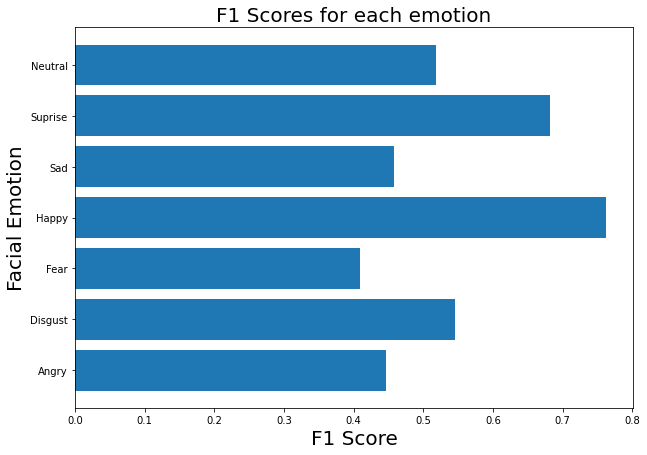

In [154]:
pred_test_proba = softmax(pred_test_proba,axis=1)   ### Predicting the probabilities using Softmax function
pred_test = (pred_test_proba == pred_test_proba.max(axis=1)[:,None]).astype(int)

report = classification_report(y_test, pred_test,target_names = ['Angry','Disgust','Fear','Happy','Sad','Suprise','Neutral'],output_dict=True)
df_report = pd.DataFrame(pd.DataFrame(report).transpose()['f1-score'])
df_report = df_report.head(-4)

plt.figure(figsize=(10,7))
plt.barh(y=df_report.index, width=df_report['f1-score'],align='center')
plt.xlabel("F1 Score",fontsize=20)
plt.ylabel("Facial Emotion",fontsize=20)
plt.title("F1 Scores for each emotion",fontsize=20)
plt.show()

The model is able to classify emotions Happy and Suprise as they have their F1-Scores close to 70%. The performance of the model can be improved when more data for the less frequenct classes are available.

## Mounting Google Drive to load Custom images

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [119]:
data_root='/content/drive/My Drive/Pictures'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
IMG_HEIGHT = 48
IMG_WIDTH = 48

train_data_gen = image_generator.flow_from_directory(directory=str(data_root),shuffle=True,color_mode = 'grayscale',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))
image_batch_train, label_batch_train = next(iter(train_data_gen))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Found 6 images belonging to 1 classes.
Image batch shape:  (6, 48, 48, 1)
Label batch shape:  (6, 1)


In [151]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
grayscale_images = []
face_cascade = cv.CascadeClassifier('./haarcascade_frontalface_alt.xml')   ### Frontface detector using Computer Vision

with tf.Session() as sess:
      img_exr = []
      saver = tf.train.import_meta_graph('./saved_model/test.meta')        ### Loaded the meta-data of the saved model 
      saver.restore(sess, tf.train.latest_checkpoint('./saved_model'))     ### Restoring everything from the saved model 
      for image in train_data_gen.filenames:
        
        image_path = './drive/My Drive/Pictures/' + image
        test_image = cv.imread(image_path)
        test_image = cv.resize(test_image, (200, 200))                     ### Resizing the custom test images
      # Convert color image to grayscale for Viola-Jones
        grayscale_image = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)
        
        detected_faces = face_cascade.detectMultiScale(grayscale_image)  
        for (column, row, width, height) in detected_faces:
          only_face = grayscale_image[row:row + height, column:column + width]    ### Cropping the face out
          face_resize = np.expand_dims(np.expand_dims(cv.resize(only_face, (48, 48)), -1), 0)  ### Resizing the cropped face to 48x48
          face_resize = face_resize - np.mean(X_data,axis=0)                                   ### Standardising the resized cropped face
          face_resize = face_resize/np.std(X_data,axis=0)
          cv.rectangle(test_image, (column, row), (column + width, row + height), (0, 255, 0), 2) ### Drawing a rectangle to indicate the face
          emotion_pred = sess.run(y_pred,feed_dict={x:face_resize,holdout_prob:0.6})              ### Emotion prediction using the trained model
          img_exr.append(cv.putText(test_image, emotions[int(np.argmax(emotion_pred))], (column, row-4), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv.LINE_AA))

      all_images_temp1 = np.concatenate(img_exr[:3],axis=1)
      all_images_temp2 = np.concatenate(img_exr[3:],axis=1)
      expressions_img = np.concatenate((all_images_temp1, all_images_temp2))

INFO:tensorflow:Restoring parameters from ./saved_model/test


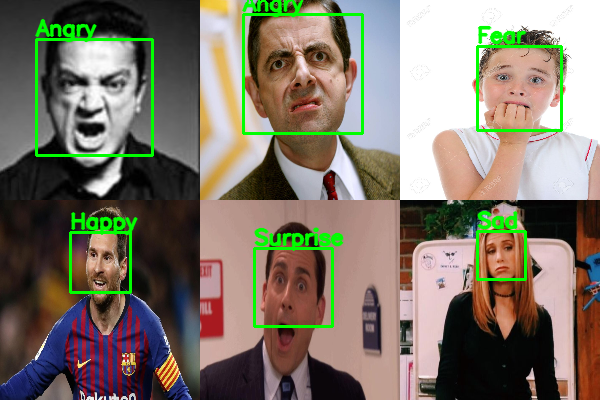

In [0]:
cv2_imshow(expressions_img)

In [0]:
cv.imwrite('facial expressions.jpg', expressions_img)

True